# Knots and bolts

The introduction assumes the reader to be at least moderatly familiar with B-splines and NURBS. We will here describe the realization of the spline technology in this library and how one as a user interacts with it.

Numpy (and scipy) is the backbone on which the library is built, and we will often use numpy containers as input and output to functions calls. We will start by importing splipy and numpy. For now, we will use pyplot as our plotting library

In [1]:
import splipy as sp
import numpy as np
import matplotlib.pyplot as plt

## BSplineBasis

Any B-spline is built up of *basis functions*, defined on a knot vector. A knot vector of order *p* (it is customary to define the polynomial order as the polynomial degree plus 1, i.e. $x^4$ is of order 5), will generate *n* basis functions if it consist of exactly *p+n* non-decreasing knots. We may compute these basis functions directly by calling the evaluate function on the BSplineBasis object.

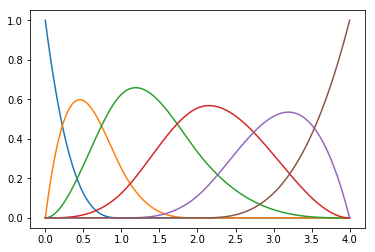

In [2]:
# create a set of cubic (order=4) B-spline basis functions
basis = sp.BSplineBasis(order=4, knots=[0,0,0,0,1,2,4,4,4,4])

# 150 uniformly spaced evaluation points on the domain (0,4)
t = np.linspace(0,4, 150)

# evaluate *all* basis functions on *all* points t. The returned variable B is a matrix
B = basis.evaluate(t) # B.shape = (150,6), 150 visualization points, 6 basis functions

# plot the basis functions
plt.plot(t, B)
plt.show()

We may also compute derivatives. Note that since the basis itself is piecewise cubic, then the second derivatives are piecewise linear.

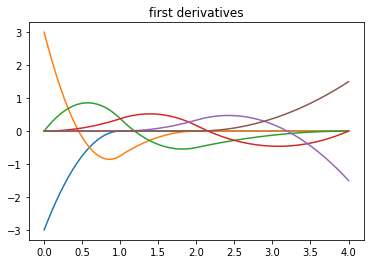

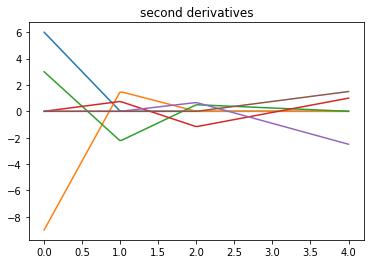

In [3]:
# compute the first derivatives
dB = basis.evaluate(t, d=1) 

plt.plot(t, dB)
plt.title('first derivatives')
plt.show()

# compute the second derivatives
ddB = basis.evaluate(t, d=2) 

plt.plot(t, ddB)
plt.title('second derivatives')
plt.show()

## Curve

Curves are defined by associating a controlpoint to each basis function.
$$ x(t) = \sum_{i=1}^n B_{i,p}(t) x_i$$
where $x_i$ are the controlpoints and $B_{i,p}(t)$ are the basis functions. $x(t)$ is the parametric curve, and by letting each controlpoint be a vector of length 1,2 or 3, we may create a curve in 1D, 2D or 3D. The framework supports curves in arbitrary dimensions, but by far the most useful are 2D and 3D curves with (x,y)-coordaintes or (x,y,z)-coordinates respectively.

(150, 2)


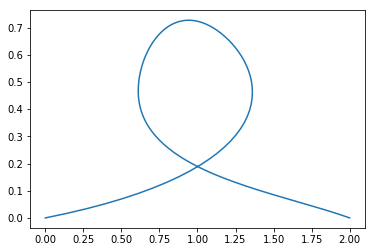

In [4]:
# create a list of 6 controlpoints (we have 6 basis functions in our basis)
controlpoints = [[  0,  0],
                 [1.8,0.2],
                 [  1,  1],
                 [0.2,0.2],
                 [1.5, 0.1],
                 [  2,  0]]
curve = sp.Curve(basis, controlpoints)

t = np.linspace(0,4,150) # 150 visualization points on our parametric domain [0,4]
x = curve.evaluate(t)    # compute (x,y)-coordinates of the curve evaluation
print(x.shape)           # 2 components at 150 evaluation points, this prints (150,2)

plt.plot(x[:,0], x[:,1])
plt.show()

We may also show the control-polygon of the curve. Controlpoints are not interpolatory, hence they do not lie on the curve itself, but acts as handles to manipulate the overall shape indirectly.

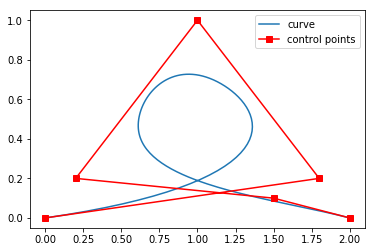

In [5]:
x = curve.evaluate(t) # we use the same evaluation points as above

plt.plot(x[:,0], x[:,1])
plt.plot(curve.controlpoints[:,0], curve.controlpoints[:,1], 'rs-')
plt.legend(('curve', 'control points'))
plt.show()

We may use parentheses and square brackets as a shorthand notation to access curve evaluation and controlpoints respectively

In [6]:
print( curve(1) ) # prints the (x,y) coordinate of the curve evaluated at the point t=1 (blue curve above)
print( curve[1] ) # prints the second (0-indexed) controlpoint (red curve above)

[ 1.1  0.7]
[ 1.8  0.2]


We may manipulate the curve directly by altering the control-points and replotting

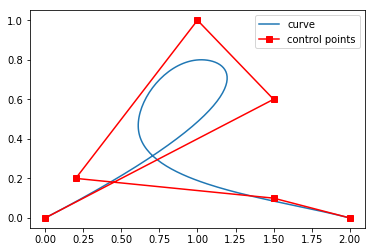

In [7]:
curve[1] = [1.5, 0.6]                   # change one of the controlpoints

x = curve(t)                            # evaluate the curve using the updated controlpoint

plt.plot(x[:,0], x[:,1])                # plot the curve itself
plt.plot(curve[:,0], curve[:,1], 'rs-') # plot the controlpoints
plt.legend(('curve', 'control points'))
plt.show()

B-spline curves are piecewise polynomial. To see the different pieces, we simply evaluate at the knots themselves

In [8]:
print(basis.knots) # these are the parametric splitting points of the curve

[ 0.  0.  0.  0.  1.  2.  4.  4.  4.  4.]


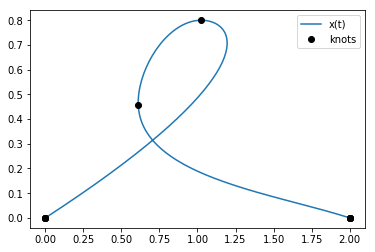

In [9]:
# first evaluate the curve
t = np.linspace(0,4,150) # 150 visualization points
x = curve(t)

# plot the curve itself
plt.plot(x[:,0], x[:,1])

# then evaluate the break-points (the knots)
t = basis.knots
x = curve(t)

# plot the breakpoints as black dots
plt.plot(x[:,0], x[:,1], 'ko ')

plt.legend(('x(t)', 'knots'))
plt.show()

We may also compute the center of gravity. This is defined as
$$ \frac{1}{t_1-t_0} \int_{t_0}^{t_1} x(t) dt$$

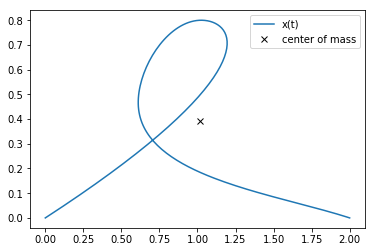

In [10]:
t = np.linspace(0,4,150)
x = curve(t)
plt.plot(x[:,0], x[:,1])

x = curve.center()
plt.plot(x[0], x[1], 'kx')

plt.legend(('x(t)', 'center of mass'))
plt.show()

We may also enrich our spline space, by inserting new knots which allow for even finer control of the curve shape and more control-points to manipulate. Inserting one new knot will add one new control-point to the curve

In [11]:
curve.insert_knot(3.2) # adds a break-point at t=3.2 This also introduces a new control point
print(len(curve))      # prints the number of control-points in the curve

7


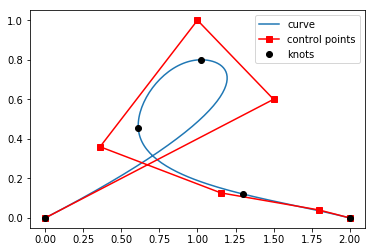

In [12]:
t = np.linspace(0,4, 150)               # 150 visualization points
x = curve(t)                            # evaluate the curve using the updated controlpoint

plt.plot(x[:,0], x[:,1])                # plot the curve itself
plt.plot(curve[:,0], curve[:,1], 'rs-') # plot the controlpoints

t = curve.knots(0)
x = curve(t)                            # evaluate the curve at the knots (breakpoints)

plt.plot(x[:,0], x[:,1], 'ko ')         # plot the knots
plt.legend(('curve', 'control points', 'knots'))
plt.show()

## Surface

A surface is built up from two BSplineBasis and accompanied by a tensor *net* of controlpoints. Using *n* basis functions of order *p* in the *u*-direction and *m* basis functions of order *q* in the *v*-direction, we may evaluate surfaces by the following expression
$$ x(u,v) = \sum_{i=1}^n\sum_{j=1}^m B_{i,p}(u)B_{j,q}(v) x_{ij}$$
where $x_{ij}$ forms the control-net

In [13]:
basis_u = sp.BSplineBasis(3, [0,0,0,1,1,1])   # quadratic basis: 3 functions in the u-direction
basis_v = sp.BSplineBasis(3, [0,0,0,1,2,2,2]) # 4 quadratic functions in the v-direction

control_net = [[0,0,0], [1,0,0], [2,0,0],
               [0,2,0], [1,2,1], [2,1,0],
               [1,3,0], [2,2,1], [3,1,0],
               [3,3,0], [3,2,0], [3,1,0]]

surface = sp.Surface(basis_u, basis_v, control_net)

Just like curves, we may evaluate the spline using parentheses and access the control-points using square brackets. 

In [14]:
print(surface(0.123, 0.22)) # evaluates the surface at the parametric point u=0.123 v=0.22
print(surface[1,1])         # prints one of the controlpoints, note that we need double-index since we have a net

[ 0.2702      0.79588841  0.08448457]
[1 2 1]


We may also evaluate surfaces on a grid of evaluation points, this is especially useful when doing plotting and need to evaluate the entire surface patch

In [15]:
x = surface([0.1, 0.2], [0.1, 0.2]) # evaluates the surface on the 2x2 grid of evaluation points
print(x.shape) # (2,2,3): 2 evaluation points in u, 2 evaluation points in v, 3 components (x,y,z)
print(x)

(2, 2, 3)
[[[ 0.205    0.38215  0.0342 ]
  [ 0.22     0.7326   0.0648 ]]

 [[ 0.405    0.3756   0.0608 ]
  [ 0.42     0.7184   0.1152 ]]]


In [16]:
u = np.linspace(0,1,31) # 31 uniformly spaced evaluation points in u (domain (0,1))
v = np.linspace(0,2,41) # 41 uniformly spaced evaluation points in u (domain (0,2))
x = surface(u,v)
print(x.shape)          # (31,41,3)
print(x[0,0,:])         # (x,y,z)-coordinate of the first evaluation point (u=0, v=0)
print(x[1,0,:])         # (x,y,z)-coordinate of the second evaluation point (u=1/30, v=0)

(31, 41, 3)
[ 0.  0.  0.]
[ 0.06666667  0.          0.        ]


To make 3D surface plots, we first need to import a few more packages

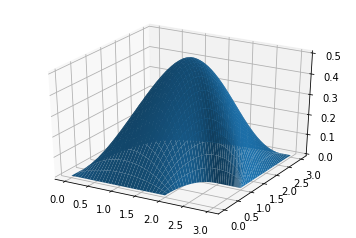

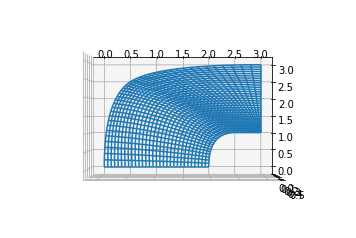

In [17]:
# first we set up our 3D plotting environment
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the (x,y,z)-coordinates of the surface (computed above)
ax.plot_surface(x[:,:,0], x[:,:,1], x[:,:,2])
plt.show()

# show a top-down meshgrid of the surface
fig = plt.figure()                                # new figure
ax = fig.add_subplot(111, projection='3d')        # 3d plot
ax.plot_wireframe(x[:,:,0], x[:,:,1], x[:,:,2])   # plot as wireframe
ax.view_init(90, -90)                             # view from above (top view)
plt.show()